In [996]:
import os
import glob
import shutil 
import numpy as np 
import pandas as pd
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler


In [997]:
feature_dir = Path('/Users/carlydrzewiecki/Desktop/trainor_cluster/extracted_features_output')


In [998]:
files_to_cluster = glob.glob(str(feature_dir/'*.csv'))

## We need to clean up these datasets and selece the correct frames to cluster

## clean data step 1 - find when intruder enters the arena

In [999]:
def trim_videostart(df):
    #Chop the first 5% of frames
    trunc_df = df.iloc[int(len(df)*.05):int(len(df)),:]
    #reset index
    trunc_df = trunc_df.reset_index(drop=True)
    return trunc_df

def find_intruder_entry(df):
    intruder_entry_frame = df.loc[~df['intruder_rearing'].isna(), 'frame']
    intruder_entry_frame = intruder_entry_frame.iloc[0]
    return intruder_entry_frame

def trim_videofinal(df, intruder_entry_frame):
    df = df.loc[df['frame'] >= intruder_entry_frame+1, :]
    df = df.reset_index(drop=True)
    #get data from first 3 minutes after intruder entry
    df = df.iloc[0:5400,:]
    return df

In [1000]:
trimmed_datalist = []

for raw_data_filename in files_to_cluster:
    raw_data = pd.read_csv(raw_data_filename)
    #add a column for the subject id
    subject_id = raw_data_filename.split('/')[-1].split('_')[0]
    raw_data['subject_id'] = subject_id
    #add a column for the session type
    session_type = raw_data_filename.split('/')[-1].split('_')[1]
    raw_data['session_type'] = session_type
    #rename the frame column
    raw_data = raw_data.rename(columns={'Unnamed: 0': 'frame'})
    #trim video
    trunc_data = trim_videostart(raw_data)
    intruder_entry_frame = find_intruder_entry(trunc_data)
    trunc_data_final = trim_videofinal(trunc_data, intruder_entry_frame)
    trimmed_datalist.append(trunc_data_final)

'Create a list of column names to ignore for data processing'
cols_to_ignore = ['frame', 'subject_id', 'session_type']

# n of trimmed_datalist should be 22 [for now...]

In [1001]:
#Features were truncated to fall within the 1st and 99th percentile of all recorded data for each feature (to remove extreme outliers) [ FROM FALKNER]

## Clean data step 1.5 - remove extreme outliers a la Falkner

In [1002]:
def percentile_with_nan(arr, percentile):
    non_nan_arr = arr[~np.isnan(arr)]
    return np.percentile(non_nan_arr, percentile)

In [1003]:
#Find the 1st and 99th percentile of each feature

outlier_dict = {}

all_raw_data = pd.concat(trimmed_datalist, ignore_index=True)
for col in all_raw_data:
    if col not in cols_to_ignore:
        maxquant = percentile_with_nan(all_raw_data[col], 99)
        minquant = percentile_with_nan(all_raw_data[col], 1)
        outlier_dict[col] = [minquant, maxquant]

In [1004]:
trimmed_datalist_no_outliers = []

for df in trimmed_datalist:
    for col in df:
        if col not in cols_to_ignore:
            #drops rows where values are outside of the 1st and 99th percentile for that column
            df = df[df[col] >= outlier_dict[col][0]]
            df = df[df[col] <= outlier_dict[col][1]]
    trimmed_datalist_no_outliers.append(df)

## clean data step 2 - SMOOTHING

In [1005]:
def gaussian_smooth(df):
    for cols in df.columns:
        if col not in cols_to_ignore:
            arr = np.array(df[cols])
            #Replace NaN values with 0
            arr[np.isnan(arr)] = 0
            # Perform Gaussian smoothing
            smoothed_arr = gaussian_filter1d(arr, sigma=2)
            smoothed_arr[np.isnan(arr)] = np.nan
            #replace the column with the smoothed column
            df[cols] = smoothed_arr
    return df
    

In [1006]:
smoothed_datalist = []

for df in trimmed_datalist_no_outliers:
    df_smooth = gaussian_smooth(df)
    smoothed_datalist.append(df_smooth)

## clean data step 3 - normalizing (-1 to 1)

In [1009]:
def normalize(df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    popped_frames = df.pop('frame')
    popped_subject = df.pop('subject_id')
    popped_session = df.pop('session_type')
    scaler.fit(df)
    scaled_data = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    scaled_df.insert(0, 'frame', popped_frames.values)
    scaled_df.insert(1, 'subject_id', popped_subject.values)
    scaled_df.insert(2, 'session_type', popped_session.values)
    return scaled_df

# def normalize_columns(df):
#     for cols in df.columns:
#         if cols != 'frame' and cols != 'subject_id':
#             'normalize the values in the column from -1 to 1'
#             df[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min()) * 2 - 1
#     return df

In [1010]:
#normalized_datalist = [normalize(df) for df in smoothed_datalist]

normalized_datalist = []

for df in smoothed_datalist:
    norm_df = normalize(df)
    normalized_datalist.append(norm_df)

assert len(normalized_datalist) == len(smoothed_datalist), "datasets not the same!"


In [1011]:
normalized_datalist[0]

,frame,subject_id,session_type,dist_between_mice,intruder_investigation,nose_to_nose_investigation,dist_from_left_wall,test_subject_rearing,intruder_rearing,test_subject_velocity,intruder_velocity,velocity_between_mice,orientation_to_intruder
0,986,7211,VP,-0.813703,-0.846966,-0.908127,0.593722,0.505902,0.689271,-0.949160,-0.784054,0.435836,-0.073965
1,987,7211,VP,-0.895208,-0.846760,-0.946324,0.595147,0.530001,0.660558,-0.913947,-0.898449,-0.915054,-0.001066
2,988,7211,VP,-0.925050,-0.835650,-0.917322,0.596755,0.427097,0.696642,-0.742137,-0.918265,-0.355152,0.126856
3,989,7211,VP,-0.948173,-0.821737,-0.865325,0.628133,0.256207,0.735331,-0.809422,-0.980344,-0.282331,0.234743
4,990,7211,VP,-0.975764,-0.816396,-0.860016,0.632587,0.234951,0.716237,-0.793552,-0.987932,-0.330759,0.762863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4237,6360,7211,VP,-0.677591,-0.611336,-0.479927,0.384703,0.421394,0.393674,-0.998507,-0.992622,-0.022184,-0.027435
4238,6361,7211,VP,-0.678842,-0.610719,-0.479268,0.385706,0.422753,0.433230,-0.998919,-0.991849,-0.045303,-0.045960
4239,6364,7211,VP,-0.690195,-0.611084,-0.480799,0.383822,0.423109,0.390008,-0.997014,-0.971432,-0.136234,0.018213
4240,6365,7211,VP,-0.692494,-0.610532,-0.480395,0.383864,0.420382,0.388478,-0.999974,-0.998471,-0.056662,0.009950


In [1012]:
'concatenate all the dfs in smoothed_datalist into one df'
#you need to make two. one with the frame and subject id, and one without

all_raw_data = pd.concat(normalized_datalist)

tsne_input_data = pd.concat(normalized_datalist, ignore_index=True)
tsne_input_data = tsne_input_data.drop(columns=['frame', 'subject_id', 'session_type'])

In [1013]:
'save the raw data with the frame and subject ID so you can map back the tsne output'
all_raw_data.to_csv('/Users/carlydrzewiecki/Desktop/trainor_cluster/outliersremoved_framesandsubjectids_n59305.csv')

In [989]:
tsne_input_data.head()

,dist_between_mice,intruder_investigation,nose_to_nose_investigation,dist_from_left_wall,test_subject_rearing,intruder_rearing,test_subject_velocity,intruder_velocity,velocity_between_mice,orientation_to_intruder
0,-0.899541,-0.857528,-0.927487,0.345235,0.422341,0.701338,-0.653911,-0.639760,-0.378863,0.102169
1,-0.912811,-0.852776,-0.920109,0.352333,0.391494,0.705875,-0.600279,-0.686793,-0.417721,0.141277
2,-0.933467,-0.842055,-0.903969,0.365755,0.338964,0.713828,-0.514539,-0.759228,-0.435741,0.196381
3,-0.953507,-0.823036,-0.877442,0.383396,0.280687,0.723271,-0.424199,-0.829130,-0.374538,0.228156
4,-0.966600,-0.793555,-0.840057,0.401821,0.232544,0.732287,-0.350605,-0.878269,-0.225756,0.198861


In [642]:
#n_components: The dimension of the space to embed into. Default is 2.
#perplexity: The perplexity is related to the number of nearest neighbors 
#that is used in other manifold learning algorithms. 
# Larger datasets usually require a larger perplexity. 
# Falkner used perplexity = 100
# Consider selecting a value between 5 and 50. 
# The choice is not extremely critical since t-SNE is quite insensitive to this parameter. Default is 30.
#n_iter: Maximum number of iterations for the optimization. Should be at least 250. Default is 1000.

tsne = TSNE(n_components=2, perplexity=100, n_iter=1000, random_state=42)

In [643]:
#fit the algorithm to the data
trunc_tsne = tsne.fit_transform(tsne_input_data)

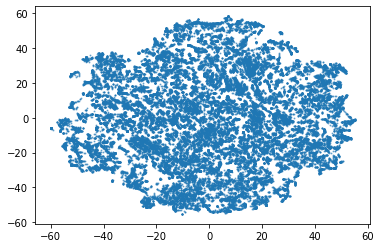

In [647]:

plt.scatter(trunc_tsne[:, 0], trunc_tsne[:, 1], s=1, alpha=0.5)
plt.show()

In [645]:
'export the tsne data to a csv file'
np.savetxt('/Users/carlydrzewiecki/Desktop/trainor_cluster/tsne_output_noextremeoutliers.csv', trunc_tsne, delimiter=',')

array([[ 10.750894 , -38.27324  ],
       [ 10.615609 , -38.258507 ],
       [ 10.452858 , -38.199455 ],
       ...,
       [ 41.253506 ,   1.1567785],
       [ 41.250114 ,   1.1539559],
       [ 41.245285 ,   1.1527032]], dtype=float32)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])